# LSTM Neural Network for Bitcoin

An LSTM (Long Short-Term Memory) neural network is a powerful deep learning model designed to handle time series data, making it an excellent choice for forecasting financial markets, including stock prices and cryptocurrencies.

LSTMs are particularly useful because they can capture long-term dependencies and patterns in data, overcoming the vanishing gradient problem commonly faced by traditional recurrent neural networks (RNNs). By using an LSTM model, investors can uncover hidden relationships and trends in historical data, which can then be utilized to make more informed trading decisions.

The model's performance can be evaluated using various metrics, such as the Mean Absolute Percentage Error (MAPE), which quantifies the average magnitude of errors between predicted and actual values.

This project showcases the efficacy of LSTMs combine with cross-validation in predicting the price of Bitcoin. The model will be trained and tested on data from the past 364 days and will require an API key from the following website: https://www.cryptocompare.com/

##### We first need to import the necessary libraries for data analysis.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import talib
import requests
import requests
import csv
import json

## Retrieving the Data

##### Let's fetch the data from CryptoCompare's API.

In [2]:
api_key = 'your_api_key'

In [ ]:
def fetch_historical_data():
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 364,
        'toTs': int(pd.Timestamp.utcnow().timestamp()),
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    json_data = response.json()
    print(json_data)  # Print json_data to debug

    historical_data = json_data['Data']['Data']
    df = pd.DataFrame(historical_data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df

# Test the function
df = fetch_historical_data()
df.head()

In [4]:
df.tail()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
360,2023-03-26,28212.64,27447.43,27493.43,29291.76,8.151863e+08,27996.81,direct,
361,2023-03-27,28044.15,26565.75,27996.81,48705.37,1.332455e+09,27145.09,direct,
362,2023-03-28,27501.44,26660.19,27145.09,38686.66,1.046551e+09,27274.90,direct,
363,2023-03-29,28640.99,27261.75,27274.90,52216.18,1.471076e+09,28355.87,direct,
364,2023-03-30,29172.90,27731.64,28355.87,62196.75,1.766565e+09,28001.35,direct,


##### Now let's preprocess the data and add the necessary features for analysis.

In [5]:
# Technical Indicators
df['SMA'] = talib.SMA(df['close'], timeperiod=14)  # Simple Moving Average (14 days)
df['EMA'] = talib.EMA(df['close'], timeperiod=14)  # Exponential Moving Average (14 days)
df['RSI'] = talib.RSI(df['close'], timeperiod=14)  # Relative Strength Index (14 days)
df['MACD'], df['MACD_signal'], _ = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # Moving Average Convergence Divergence
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['close'], timeperiod=20)  # Bollinger Bands (20 days)
df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)  # Average True Range (14 days)
df['%K'], df['%D'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3, slowd_period=3)  # Stochastic Oscillator
df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)  # Commodity Channel Index (14 days)
df['OBV'] = talib.OBV(df['close'], df['volumeto'])  # On Balance Volume
df['ROC'] = talib.ROC(df['close'], timeperiod=10)  # Rate of Change (10 days)
df['PSAR'] = talib.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)  # Parabolic Stop and Reverse

# Calculate VWAP
typical_price = (df['high'] + df['low'] + df['close']) / 3
cumulative_typical_price_volume = (typical_price * df['volumeto']).cumsum()
cumulative_volume = df['volumeto'].cumsum()

df['VWAP'] = cumulative_typical_price_volume / cumulative_volume


# Price-derived features
df['daily_return'] = df['close'].pct_change()  # Daily return
df['log_return'] = np.log(df['close'] / df['close'].shift(1))  # Log return

# Time-based features
df['day_of_week'] = df['time'].dt.dayofweek  # Day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)


# Drop missing values
df.dropna(inplace=True)

# Select only the columns that you want to use as features
feature_columns = ['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 
                   'BB_upper', 'BB_middle', 'BB_lower', 'daily_return', 'log_return', 
                   'day_of_week', 'ATR', '%K', 'CCI', 'OBV', 'ROC', 'PSAR', 'VWAP']
numerical_data = df[feature_columns]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Create a new DataFrame with scaled data
scaled_data = pd.DataFrame(scaled_numerical_data, columns=numerical_data.columns, index=numerical_data.index)

# Split the data into training and testing sets
train_data, test_data = scaled_data[:int(len(df) * 0.75)], scaled_data[int(len(df) * 0.75):]

In [45]:
df.tail()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,SMA,...,%K,%D,CCI,OBV,ROC,PSAR,VWAP,daily_return,log_return,day_of_week
360,2023-03-26,28212.64,27447.43,27493.43,29291.76,8.151863e+08,27996.81,direct,,26819.611429,...,85.179421,86.666260,59.877901,-3.701136e+10,11.757868,25449.556183,23955.226082,0.018309,0.018144,6
361,2023-03-27,28044.15,26565.75,27996.81,48705.37,1.332455e+09,27145.09,direct,,27029.559286,...,78.604218,83.752845,17.083369,-3.834381e+10,-1.076728,25860.868641,23966.115219,-0.030422,-0.030894,0
362,2023-03-28,27501.44,26660.19,27145.09,38686.66,1.046551e+09,27274.90,direct,,27209.287143,...,73.236013,79.006551,-0.129603,-3.729726e+10,1.117843,26222.823604,23974.342870,0.004782,0.004771,1
363,2023-03-29,28640.99,27261.75,27274.90,52216.18,1.471076e+09,28355.87,direct,,27494.052143,...,73.708613,75.182948,81.239140,-3.582618e+10,1.136164,26541.343971,23989.245662,0.039632,0.038867,2
364,2023-03-30,29172.90,27731.64,28355.87,62196.75,1.766565e+09,28001.35,direct,,27704.769286,...,76.189789,74.378138,120.397271,-3.759275e+10,0.697875,26660.190000,24007.934768,-0.012503,-0.012581,3


## Visualizing the Technical Indicators

##### Simple Moving Average (SMA)

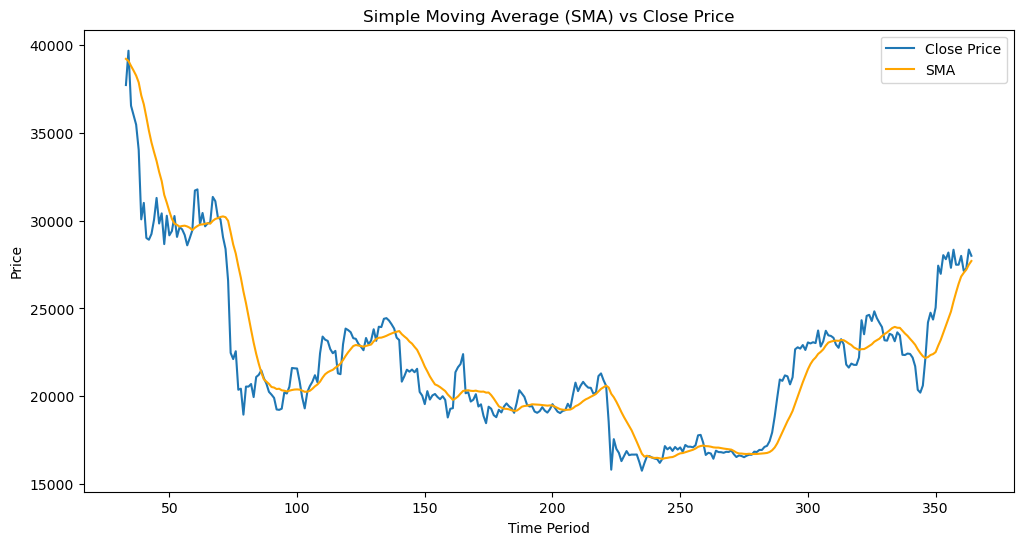

In [95]:
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Close Price')
plt.plot(df['SMA'], label='SMA', color = 'orange')
plt.title('Simple Moving Average (SMA) vs Close Price')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend()
plt.show()

The SMA is an average of the closing prices over a specified period. It helps investors identify trends by smoothing out the price data, making it easier to spot overall price direction. A rising SMA indicates an uptrend, while a falling SMA suggests a downtrend.

##### Exponential Moving Average (EMA)

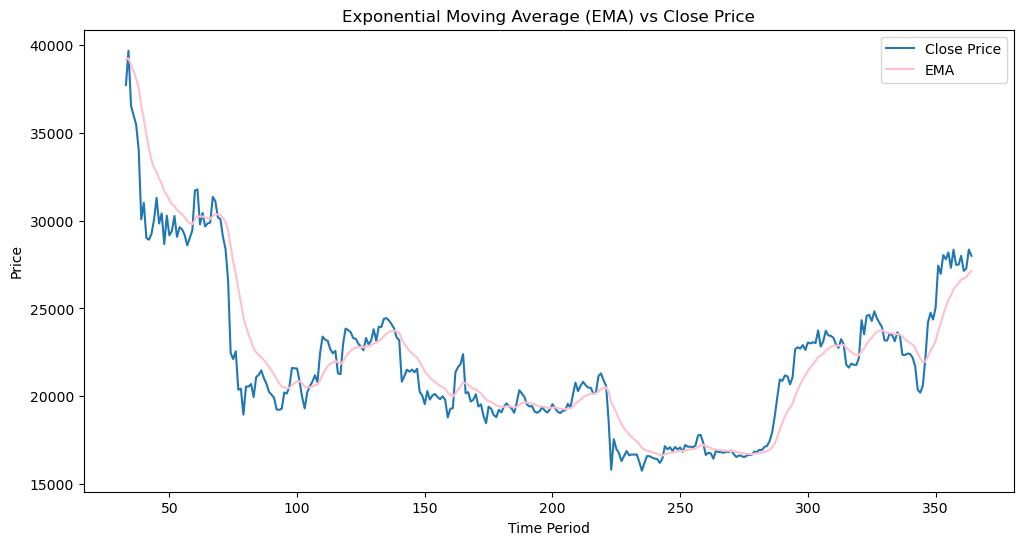

In [99]:
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Close Price')
plt.plot(df['EMA'], label='EMA', color = 'pink')
plt.title('Exponential Moving Average (EMA) vs Close Price')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend()
plt.show()

Similar to the SMA, the EMA also calculates an average of closing prices over a specified period. However, it gives more weight to recent prices, making it more responsive to new information. This responsiveness can help investors identify trend reversals more quickly.

##### Relative Strength Index (RSI)

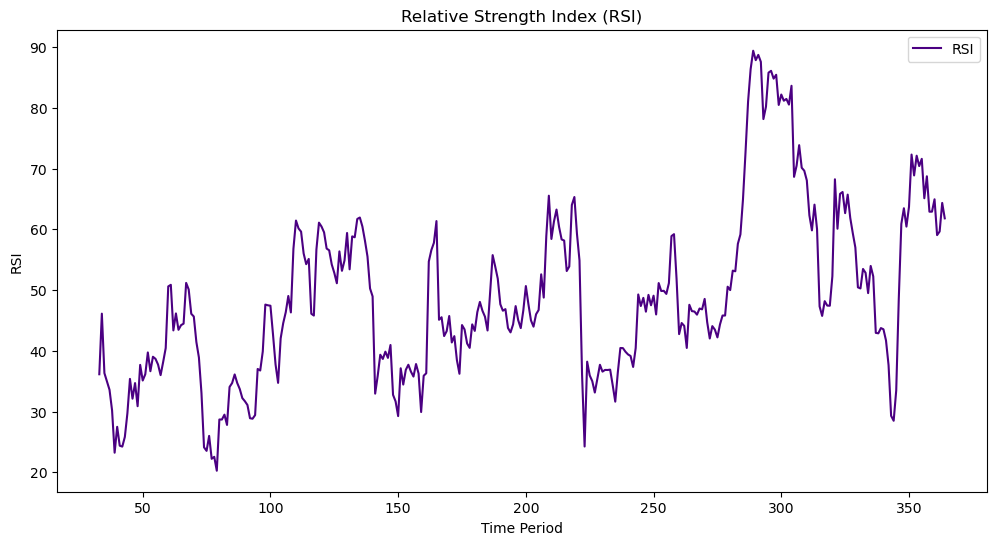

In [92]:
plt.figure(figsize=(12,6))
plt.plot(df['RSI'], label='RSI', color = 'indigo')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Time Period')
plt.ylabel('RSI')
plt.legend()
plt.show()

RSI is a momentum oscillator that measures the speed and change of price movements. It can help investors identify overbought and oversold conditions, providing potential entry and exit points for trades.

##### Moving Average Convergence Divergence (MACD)

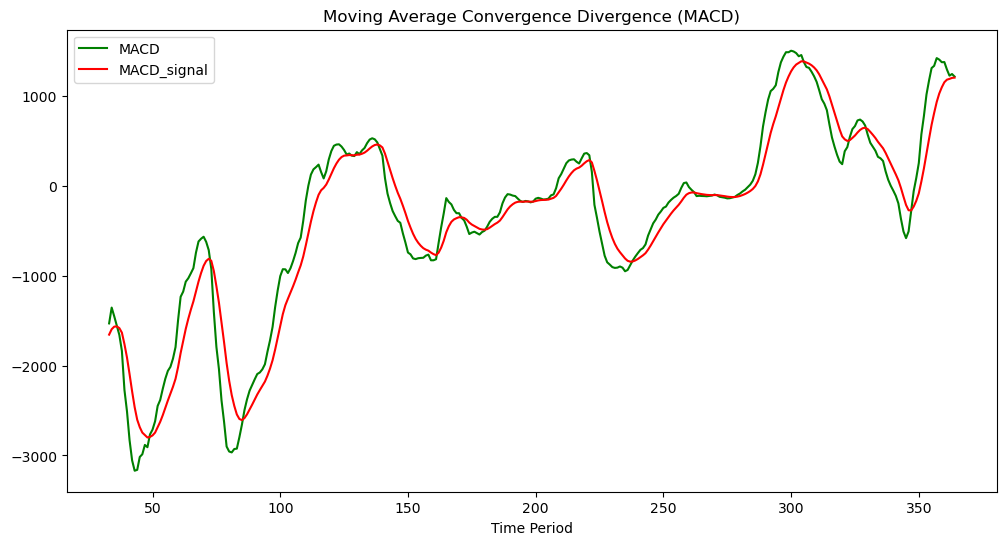

In [91]:
plt.figure(figsize=(12,6))
plt.plot(df['MACD'], label='MACD', color = 'g')
plt.plot(df['MACD_signal'], label='MACD_signal', color = 'r')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Time Period')
plt.legend()
plt.show()

MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It can signal potential trend reversals and provide insight into the strength of a trend.

##### Bollinger Bands

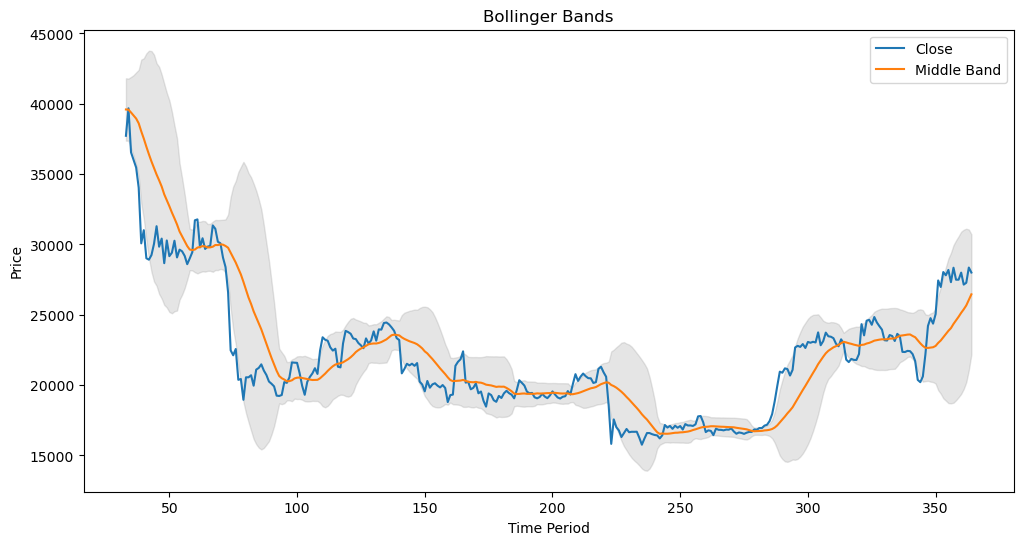

In [71]:
plt.figure(figsize=(12,6))

# Plot the close price
plt.plot(df['close'], label='Close')

# Plot the Bollinger Bands ribbon
plt.fill_between(df.index, df['BB_lower'], df['BB_upper'], alpha=0.2, color='grey')

# Plot the middle band as a line
plt.plot(df['BB_middle'], label='Middle Band')

# Set the title and legend
plt.title('Bollinger Bands')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

Bollinger Bands are a volatility indicator that consists of a middle band (SMA) and two outer bands, which are standard deviations away from the middle band. The bands expand and contract based on price volatility, helping investors identify potential overbought and oversold conditions.

##### Average True Range (ATR)

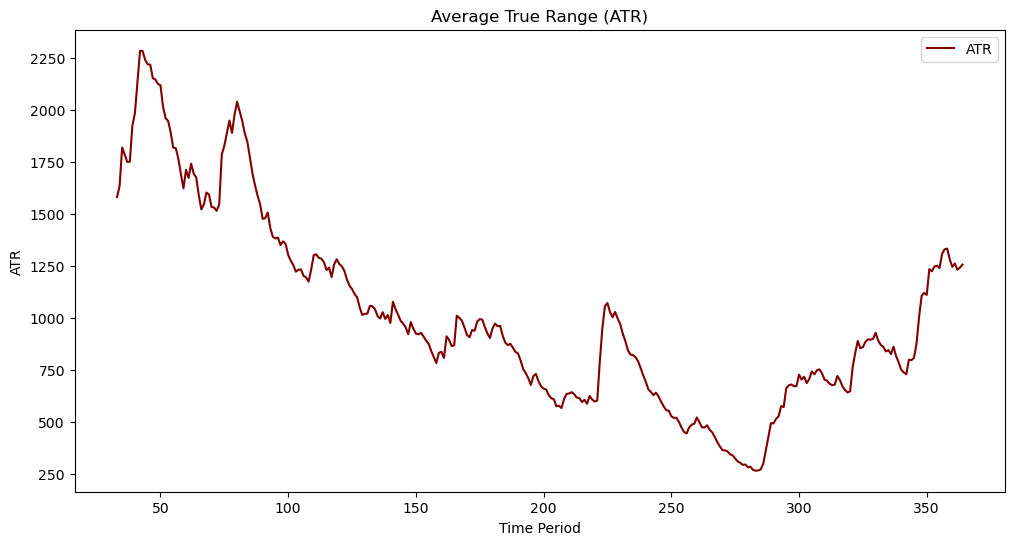

In [90]:
plt.figure(figsize=(12,6))
plt.plot(df['ATR'], label='ATR', color = 'maroon')
plt.title('Average True Range (ATR)')
plt.xlabel('Time Period')
plt.ylabel('ATR')
plt.legend()
plt.show()

ATR is a volatility indicator that measures the degree of price movement within a specified period. It can help investors determine the appropriate stop-loss and take-profit levels, as well as assess the risk associated with a particular trade.

##### Stochastic Oscillator (%K and %D)

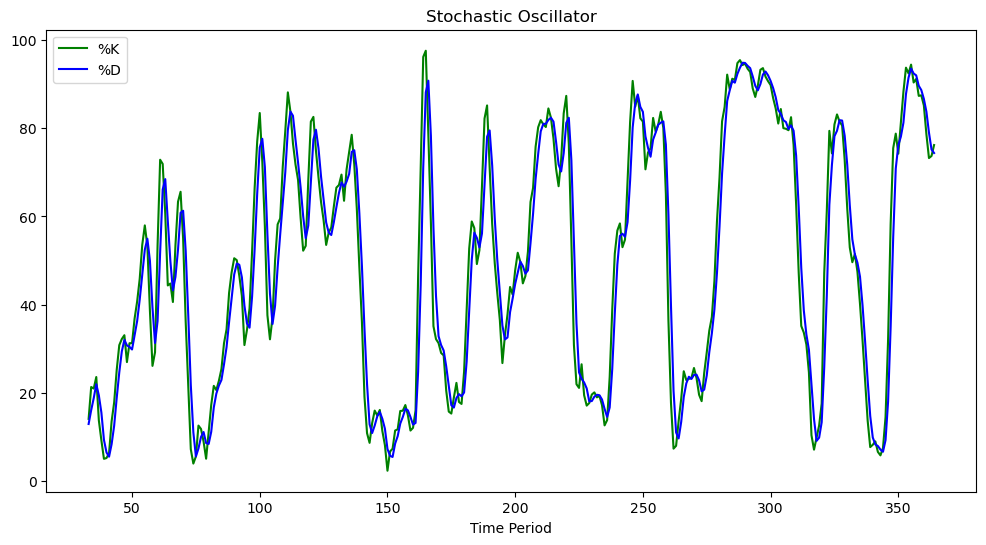

In [89]:
plt.figure(figsize=(12,6))
plt.plot(df['%K'], label='%K', color = 'g')
plt.plot(df['%D'], label='%D', color = 'b')
plt.title('Stochastic Oscillator')
plt.xlabel('Time Period')
plt.legend()
plt.show()

The Stochastic Oscillator is a momentum indicator that compares a security's closing price to its price range over a specified period. It helps investors identify potential trend reversals and overbought or oversold conditions.

##### Commodity Channel Index (CCI)

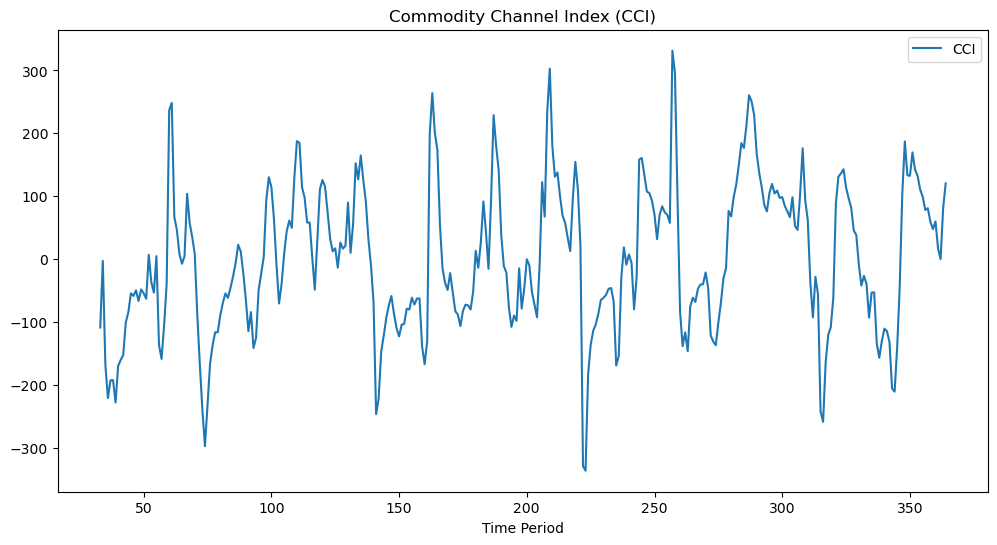

In [74]:
plt.figure(figsize=(12,6))
plt.plot(df['CCI'], label='CCI')
plt.title('Commodity Channel Index (CCI)')
plt.xlabel('Time Period')
plt.legend()
plt.show()

CCI is a momentum oscillator that measures the deviation of a security's price from its statistical mean. It can help investors identify potential price reversals and overbought or oversold conditions.

##### On Balance Volume (OBV)

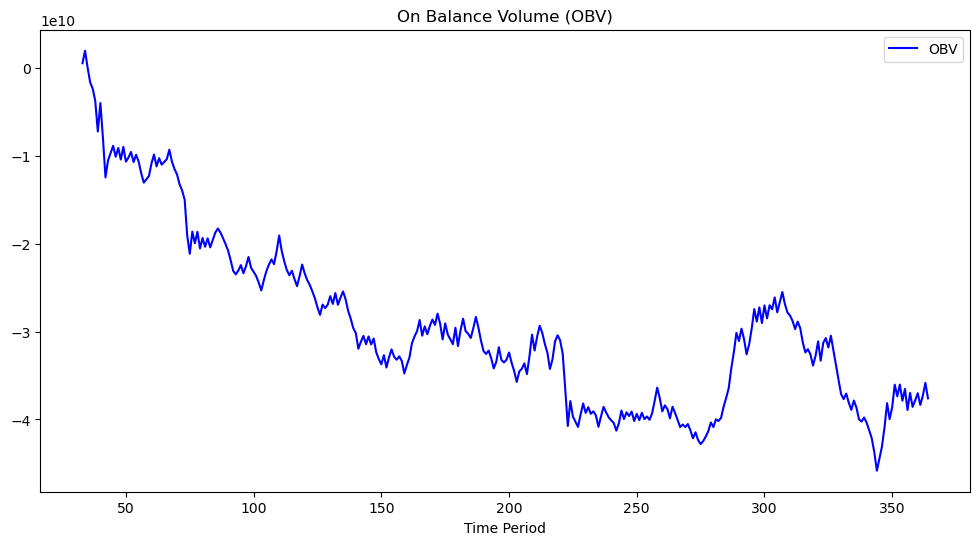

In [86]:
plt.figure(figsize=(12,6))
plt.plot(df['OBV'], label='OBV', color = 'b')
plt.title('On Balance Volume (OBV)')
plt.xlabel('Time Period')
plt.legend()
plt.show()

OBV is a volume-based indicator that measures buying and selling pressure. It can help investors confirm price trends and identify potential trend reversals based on changes in volume.

##### Rate of Change (ROC)

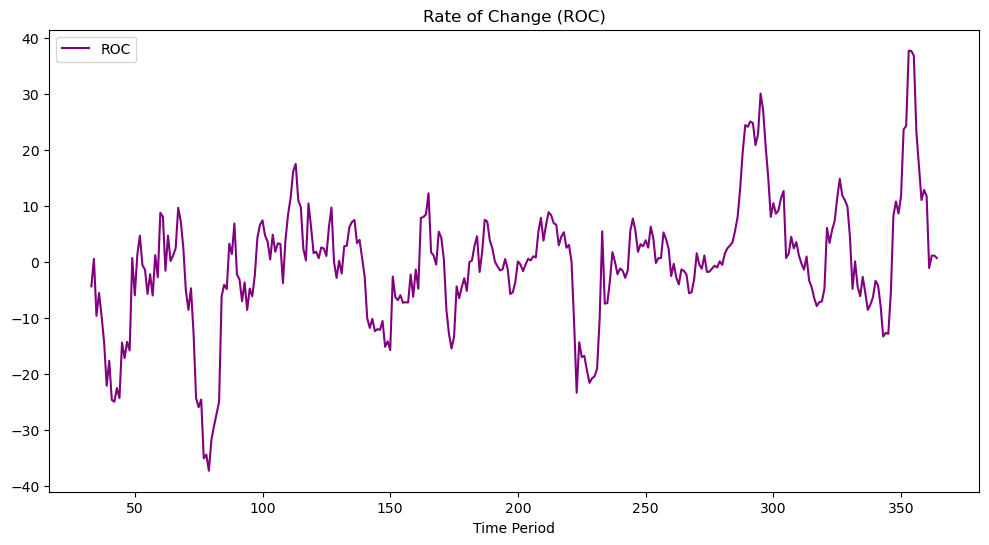

In [85]:
plt.figure(figsize=(12,6))
plt.plot(df['ROC'], label='ROC', color = 'purple')
plt.legend()
plt.title('Rate of Change (ROC)')
plt.xlabel('Time Period')
plt.show()

ROC is a momentum oscillator that measures the percentage change in price over a specified period. It can help investors identify potential trend reversals and gauge the strength of a trend.

##### Parabolic Stop and Reverse (PSAR)

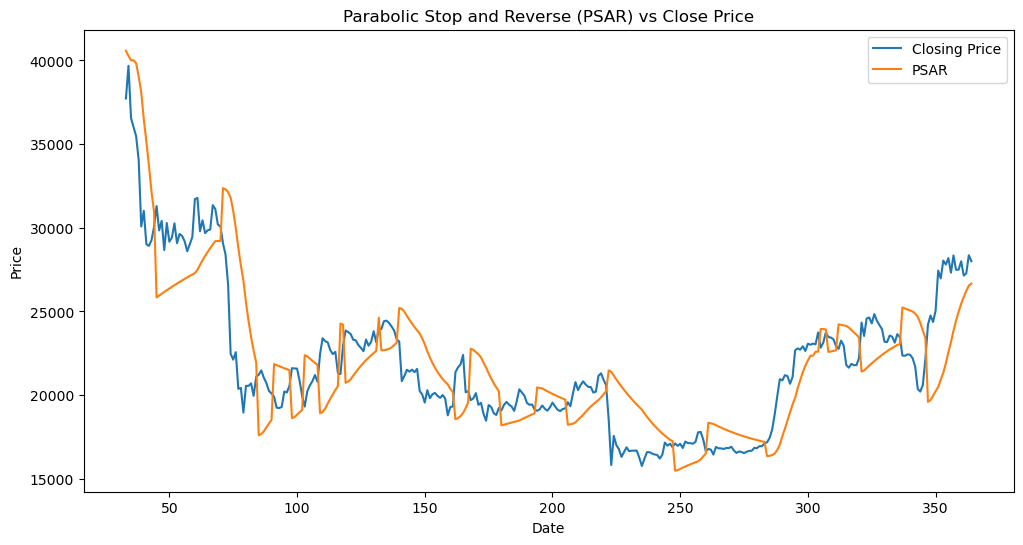

In [77]:
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Closing Price')
plt.plot(df['PSAR'], label='PSAR')
plt.legend()
plt.title('Parabolic Stop and Reverse (PSAR) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

PSAR is a trend-following indicator that provides potential entry and exit points for trades. It helps investors determine the direction of a trend and can also be used as a trailing stop loss.

##### Volume Weighted Average Price (VWAP)

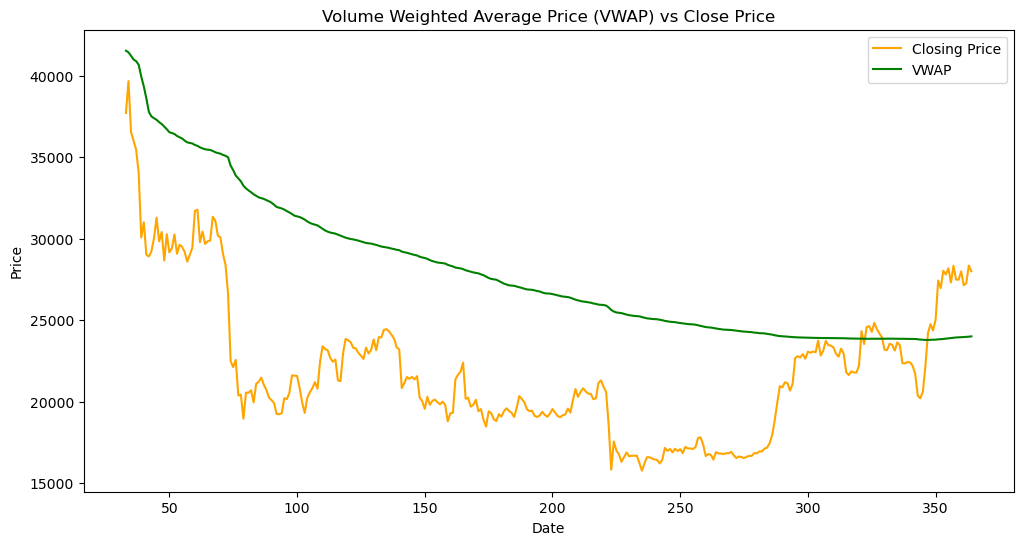

In [84]:
plt.figure(figsize=(12,6), )
plt.plot(df['close'], label='Closing Price', color = 'orange')
plt.plot(df['VWAP'], label='VWAP', color = 'g')
plt.legend()
plt.title('Volume Weighted Average Price (VWAP) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

VWAP is the average price of a security, weighted by volume. It provides a benchmark for investors to assess the quality of their trade execution and can also be used as a support and resistance level for intraday trading.

## Splitting the Data

##### We now split the data into the X,y train/test.

In [8]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [9]:
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i - window_size:i].values)
        y.append(df.iloc[i, 0])  # Assuming the target variable is the 'close' price
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [10]:
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))
print('\n')
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)

Length of train_data: 249
Length of test_data: 83


X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


## Making the LSTM Neural Network Model

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

## Evaluating the Model's Performance

In [12]:
train_loss = np.mean(model.evaluate(X_train, y_train, verbose=0))
test_loss = np.mean(model.evaluate(X_test, y_test, verbose=0))
print(f'Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}')

Train Loss: 0.00119, Test Loss: 0.14291


In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 37ms/step


In [14]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train = np.zeros_like(X_train)
dummy_test = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the reshaped predicted values
dummy_train[:, :, 0] = y_train_pred
dummy_test[:, :, 0] = y_test_pred

# Perform the inverse transformation on the dummy arrays
y_train_pred_unscaled = scaler.inverse_transform(dummy_train[:, 0, :])[:, 0]
y_test_pred_unscaled = scaler.inverse_transform(dummy_test[:, 0, :])[:, 0]

In [16]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train_y = np.zeros_like(X_train)
dummy_test_y = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the actual y values
dummy_train_y[:, :, 0] = y_train.reshape(-1, 1)
dummy_test_y[:, :, 0] = y_test.reshape(-1, 1)

# Perform the inverse transformation on the dummy arrays
y_train_unscaled = scaler.inverse_transform(dummy_train_y[:, 0, :])[:, 0]
y_test_unscaled = scaler.inverse_transform(dummy_test_y[:, 0, :])[:, 0]

In [17]:
train_rmse = np.sqrt(mean_squared_error(y_train_unscaled, y_train_pred_unscaled))
test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
print(f'Train RMSE: {train_rmse:.5f}, Test RMSE: {test_rmse:.5f}')

Train RMSE: 824.39617, Test RMSE: 9042.71741


The test RMSE is higher than the train RMSE (as expected), but not by a significan amount. To see how well the model actually performed, let's visualize the predictions versus the actual data.

##### Visualizing the results.

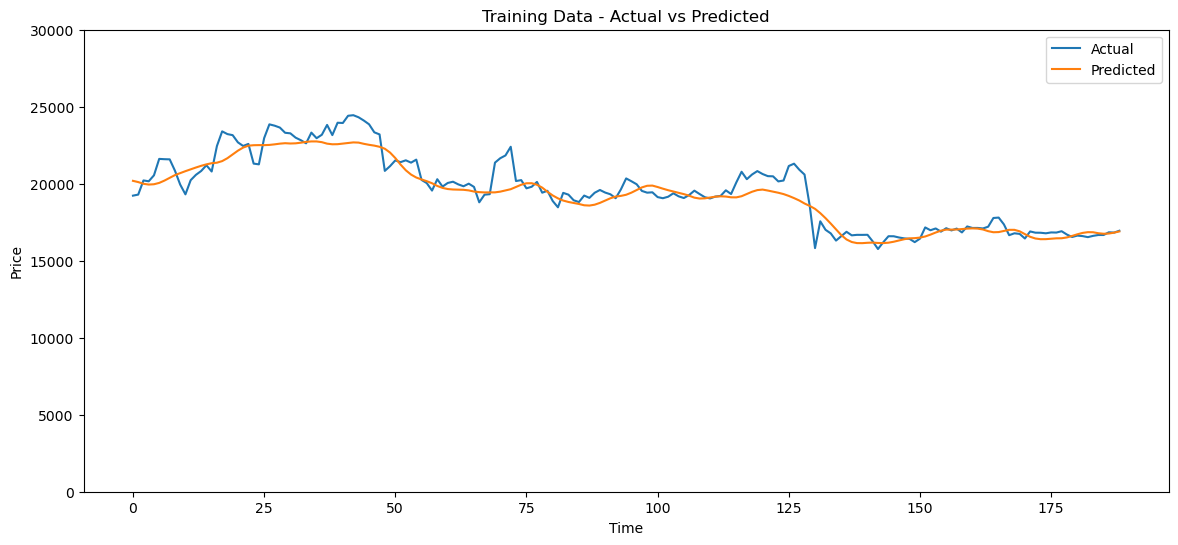

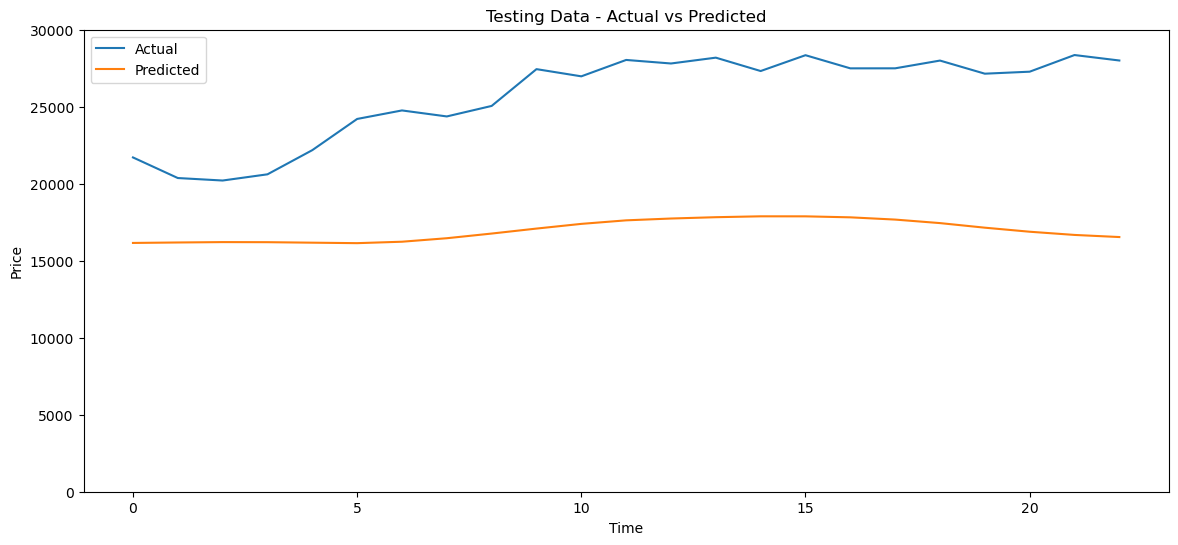

In [79]:
# For training data
plt.figure(figsize=(14, 6))
plt.plot(y_train_unscaled, label='Actual')
plt.plot(y_train_pred_unscaled, label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.ylim(0,30000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# For testing data
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(y_test_pred_unscaled, label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.ylim(0,30000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
train_mape = mean_absolute_percentage_error(y_train_unscaled, y_train_pred_unscaled)
test_mape = mean_absolute_percentage_error(y_test_unscaled, y_test_pred_unscaled)

print(f'Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%')

Train MAPE: 2.96%, Test MAPE: 33.40%


As you can see, the model has performed extremely well! By adding additional features, the model can be made more accurate and eventually used to invest into Bitcoin, and other cryptocurrencies if modified accordingly. The results show that Bitcoin is overvalued, and for a short-term investor/daytrader, this may be a good time to sell.

## 5-fold Cross Validation

The code below demonstrates how cross-validation can be used on Bitcoin's historical pricing data across 5 folds. The model is trained and validated on each fold.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def lstm_cross_validation(X, y, n_splits=5, scaler=None):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_values, mape_values, accuracy_values = [], [], []
    predictions, true_values = [], []  # Add lists to store predictions and true_values

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create and train the model
        model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

        # Make predictions
        y_test_pred = model.predict(X_test)

        # Unscale the predictions and true values
        y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
        y_test_reshaped = y_test.reshape(-1, 1)
        dummy_test = np.zeros((y_test_pred_reshaped.shape[0], X_test.shape[2] - 1))

        y_test_pred_unscaled = scaler.inverse_transform(np.hstack((y_test_pred_reshaped, dummy_test)))[:, 0]
        y_test_unscaled = scaler.inverse_transform(np.hstack((y_test_reshaped, dummy_test)))[:, 0]

        predictions.append(y_test_pred_unscaled)  # Append unscaled predictions
        true_values.append(y_test_unscaled)  # Append unscaled true_values

        # Calculate the RMSE
        rmse = sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
        rmse_values.append(rmse)

        # Calculate the MAPE
        mape = np.mean(np.abs((y_test_unscaled - y_test_pred_unscaled) / y_test_unscaled)) * 100
        mape_values.append(mape)

    return rmse_values, mape_values, predictions, true_values  # Return predictions and true_values

# Prepare the data using the create_sequences function
window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Call the lstm_cross_validation function
rmse_values, mape_values, predictions, true_values = lstm_cross_validation(X, y, n_splits=5, scaler=scaler)

In [25]:
# Concatenate the true_values and predictions lists
true_values_concat = np.concatenate(true_values, axis=0)
predictions_concat = np.concatenate(predictions, axis=0)

##### Visualizing the results

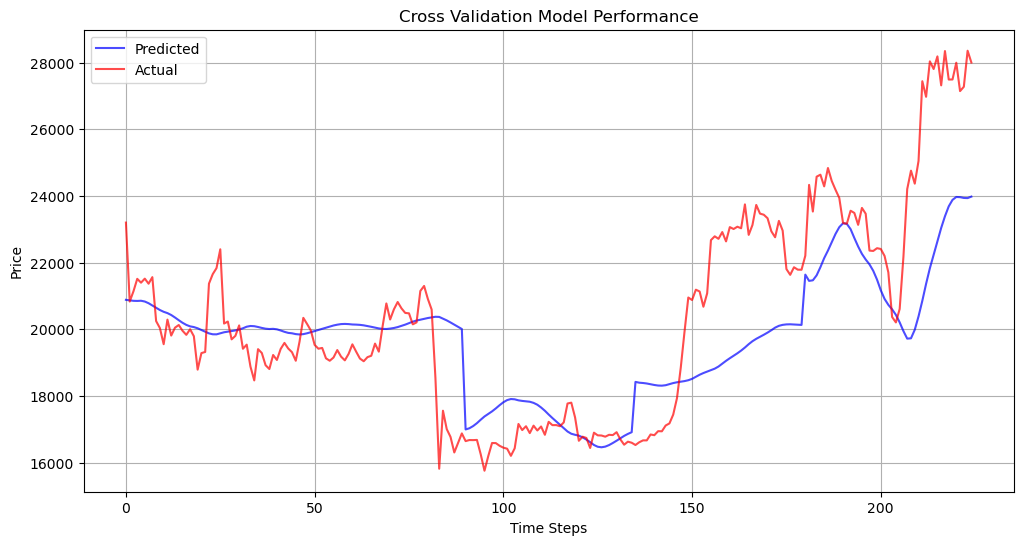

RMSE: 1840.53859
Average MAPE: 7.00%


In [47]:
import matplotlib.pyplot as plt

mean_rmse = np.mean(rmse_values)
mean_mape = np.mean(mape_values)

def plot_cross_validation_results(predictions, true_values, mean_rmse, mean_mape):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted', color='blue', alpha=0.7)
    plt.plot(true_values, label='Actual', color='red', alpha=0.7)
    plt.title('Cross Validation Model Performance')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"RMSE: {mean_rmse:.5f}")
    print(f"Average MAPE: {mean_mape:.2f}%")

# Call the function to plot the cross-validation results
plot_cross_validation_results(predictions_concat, true_values_concat, mean_rmse, mean_mape)

A MAPE of 7% after cross-validation indicates that the LSTM model's predictions deviate from the true values by an average of 7%. This relatively low error rate suggests that the LSTM model is accurately capturing the underlying dynamics of the time series data, potentially providing investors with valuable insights for decision-making and risk management in the financial markets.